# Lab 1 - Checkpoint 2

## Part C - SVM

In [ ]:
import kagglehub
import pandas as pd
import os

# Download dataset
path = kagglehub.dataset_download(
    "omnamahshivai/surgical-dataset-binary-classification"
)

print("Dataset downloaded to:", path)

# List files in the dataset directory
files = os.listdir(path)

print("Files:", files)

# Load the CSV file (update name if needed)
csv_file = "Surgical-deepnet.csv"  # this is the main file in the dataset
csv_path = os.path.join(path, csv_file)
df = pd.read_csv(csv_path)

# Basic info
print("Dataset shape:", df.shape)
print(df.head())

# Check for duplicate rows
num_duplicates = df.duplicated().sum()

print("Number of duplicate rows:", num_duplicates)

# View duplicates
if num_duplicates > 0:
    duplicates = df[df.duplicated()]
    print("Sample duplicate rows:")

# Remove duplicates
df_no_duplicates = df.drop_duplicates()
print("Shape after removing duplicates:", df_no_duplicates.shape)

# Check for missing values in each column
missing_per_column = df_no_duplicates.isna().sum()

print("Missing values per column:")
print(missing_per_column)

# Total number of missing values in the dataset
total_missing = missing_per_column.sum()
print("\nTotal missing values in dataset:", total_missing)

# Percentage of missing values per column
missing_percentage = (missing_per_column / len(df_no_duplicates)) * 100

print("\nMissing percentage per column:")
print(missing_percentage)

# Show only columns that actually have missing values
columns_with_missing = missing_per_column[missing_per_column > 0]

if not columns_with_missing.empty:
    print("\nColumns with missing values:")
    print(columns_with_missing)
else:
    print("\nNo missing values found in the dataset.")

complication_sum = df_no_duplicates["complication"].sum()
mort30_sum = df_no_duplicates["mort30"].sum()

print("Sum of complication:", complication_sum)
print("Sum of mort30:", mort30_sum)

# Drop unwanted columns
df_clean = df_no_duplicates.drop(
    columns=["mort30", "moonphase", "month", "dow", "hour"],
    errors="ignore"
)

# Split features / target
X = df_clean.drop(columns=["complication"])
y = df_clean["complication"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 123, shuffle=True)

Using Colab cache for faster access to the 'surgical-dataset-binary-classification' dataset.
Dataset downloaded to: /kaggle/input/surgical-dataset-binary-classification
Files: ['Surgical-deepnet.csv']
Dataset shape: (14635, 25)
     bmi   Age  asa_status  ...  mortality_rsi  race  complication
0  19.31  59.2           1  ...          -0.43     1             0
1  18.73  59.1           0  ...          -0.41     1             0
2  21.85  59.0           0  ...           0.08     1             0
3  18.49  59.0           1  ...          -0.32     1             0
4  19.70  59.0           1  ...           0.00     1             0

[5 rows x 25 columns]
Number of duplicate rows: 2902
Sample duplicate rows:
Shape after removing duplicates: (11733, 25)
Missing values per column:
bmi                    0
Age                    0
asa_status             0
baseline_cancer        0
baseline_charlson      0
baseline_cvd           0
baseline_dementia      0
baseline_diabetes      0
baseline_digestive   

## Part C

# 8. Going with 3 fold CV
We will utilize this to tune our 2-3 params for the SVC model with a specified kernel  

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    "C": [0.00001],
    "gamma": ["scale", 0.1],
    "kernel":["poly", "rbf"],
}

svc = SVC()

grid = GridSearchCV(
    svc,
    param_grid,
    cv=3,          # 3-fold cross-validation
    scoring="accuracy",
    verbose=3
)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 123, shuffle=True)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END .C=1e-05, gamma=scale, kernel=poly;, score=0.685 total time=   3.2s
[CV 2/3] END .C=1e-05, gamma=scale, kernel=poly;, score=0.685 total time=   5.1s
[CV 3/3] END .C=1e-05, gamma=scale, kernel=poly;, score=0.685 total time=   3.0s
[CV 1/3] END ..C=1e-05, gamma=scale, kernel=rbf;, score=0.685 total time=   4.8s
[CV 2/3] END ..C=1e-05, gamma=scale, kernel=rbf;, score=0.685 total time=   3.5s
[CV 3/3] END ..C=1e-05, gamma=scale, kernel=rbf;, score=0.685 total time=   2.5s
[CV 1/3] END ...C=1e-05, gamma=0.1, kernel=poly;, score=0.734 total time=  28.9s
[CV 2/3] END ...C=1e-05, gamma=0.1, kernel=poly;, score=0.748 total time=  35.4s
[CV 3/3] END ...C=1e-05, gamma=0.1, kernel=poly;, score=0.743 total time=  28.0s
[CV 1/3] END ....C=1e-05, gamma=0.1, kernel=rbf;, score=0.685 total time=   2.5s
[CV 2/3] END ....C=1e-05, gamma=0.1, kernel=rbf;, score=0.685 total time=   3.5s
[CV 3/3] END ....C=1e-05, gamma=0.1, kernel=rbf;,

Test accuracy: 0.7457386363636364
Confusion Matrix:
 [[2328   94]
 [ 801  297]]


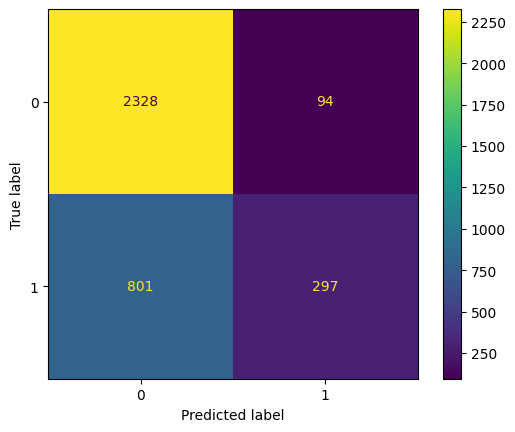

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
svc_tuned = SVC(C = 1e-5, gamma = 0.1, kernel="poly", random_state=123)
svc_tuned.fit(X_train, y_train)

# Accuracy
y_pred = svc_tuned.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## Part D

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
import numpy as np

best_params = {'C': 1e-5, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
svc_model = SVC(**best_params)

# Internal 5-fold CV to calibrate the model
calibrated_svc = CalibratedClassifierCV(
    estimator=svc_model,
    method='sigmoid',
    cv=5
)

calibrated_svc.fit(X_train, y_train)

# Threshold Optimization
X_sub_train, X_val, y_sub_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123, stratify=y_train
)

# Probabilities for threshold selection
val_probs = calibrated_svc.predict_proba(X_val)[:, 1]

cost_fn = 5
cost_fp = 1
thresholds = np.linspace(0, 1, 101)
costs = []

for t in thresholds:
    preds_t = (val_probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, preds_t).ravel()
    costs.append((fp * cost_fp) + (fn * cost_fn))

best_threshold = thresholds[np.argmin(costs)]

# Final Report on Test Set
test_probs = calibrated_svc.predict_proba(X_test)[:, 1]
final_preds = (test_probs >= best_threshold).astype(int)

print(f"Optimal Threshold: {best_threshold:.2f}")
print(classification_report(y_test, final_preds))

Optimal Threshold: 0.21
              precision    recall  f1-score   support

           0       0.88      0.33      0.48      1612
           1       0.38      0.90      0.53       735

    accuracy                           0.51      2347
   macro avg       0.63      0.61      0.51      2347
weighted avg       0.72      0.51      0.50      2347



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

default_preds = (test_probs >= 0.5).astype(int)

cm_default = confusion_matrix(y_test, default_preds)
print("Default Threshold")
print("Confusion Matrix:\n", cm_default)
print(classification_report(y_test, default_preds))

cm_opt = confusion_matrix(y_test, final_preds)
print("\nOptimized Threshold")
print(f"Threshold = {best_threshold:.2f}")
print("Confusion Matrix:\n", cm_opt)
print(classification_report(y_test, final_preds))

metrics_default = {
    "accuracy": accuracy_score(y_test, default_preds),
    "precision": precision_score(y_test, default_preds),
    "recall": recall_score(y_test, default_preds),
    "f1": f1_score(y_test, default_preds)
}

metrics_opt = {
    "accuracy": accuracy_score(y_test, final_preds),
    "precision": precision_score(y_test, final_preds),
    "recall": recall_score(y_test, final_preds),
    "f1": f1_score(y_test, final_preds)
}

print("\nMetric Summary")
print("Default:", metrics_default)
print("Optimized:", metrics_opt)

Default Threshold
Confusion Matrix:
 [[1519   93]
 [ 493  242]]
              precision    recall  f1-score   support

           0       0.75      0.94      0.84      1612
           1       0.72      0.33      0.45       735

    accuracy                           0.75      2347
   macro avg       0.74      0.64      0.65      2347
weighted avg       0.74      0.75      0.72      2347


Optimized Threshold
Threshold = 0.21
Confusion Matrix:
 [[ 531 1081]
 [  75  660]]
              precision    recall  f1-score   support

           0       0.88      0.33      0.48      1612
           1       0.38      0.90      0.53       735

    accuracy                           0.51      2347
   macro avg       0.63      0.61      0.51      2347
weighted avg       0.72      0.51      0.50      2347


Metric Summary
Default: {'accuracy': 0.7503195568811248, 'precision': 0.7223880597014926, 'recall': 0.3292517006802721, 'f1': 0.4523364485981308}
Optimized: {'accuracy': 0.5074563272262462, 'precis

## Part C - SVM

### 8. 3 fold CV on validation set
- Parameters we will tune:
  - `kernel`
  - `C`
  - `Gamma`

- We utilized gird search which was testing permutations of different hyperparams and outputting the best one
  - pulled out a validation set from our training data
  - used that data to run grid with 3 different hyperparameters listed above
  - evaluation technique we used was 3 fold cross validation

### 9. Comparing SVM to Baseline from last week

In part B, our baseline model achieved an accuracy of 74.98%, This week, our model achieved an accuracy of 74.57% in part C. Thus our models are very similar in accuracy and there is likely no statistically significant accuracy difference between KNN in part B and our SVC in part C.

### 10. Experiment Log - EDIT BASED ON SUPPLEMENT FOR SUBMISSION
Below are the logs for baseline and SVM variants:
- Both had `random_state=123`

#### Baseline from Part B
- In part B, we stuck with typical KNN best practice and set the numbers of neighbors to $\le$ $\sqrt{n}$.
  - Thus, we set the nearest neighbors value to 71
```
nearest_neighbors=71
KNN_accuracy_score=0.749893481039625
```

#### Grid Search Results from Part C
```
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END .C=1e-05, gamma=scale, kernel=poly;, score=0.685 total time=   3.2s
[CV 2/3] END .C=1e-05, gamma=scale, kernel=poly;, score=0.685 total time=   5.1s
[CV 3/3] END .C=1e-05, gamma=scale, kernel=poly;, score=0.685 total time=   3.0s
[CV 1/3] END ..C=1e-05, gamma=scale, kernel=rbf;, score=0.685 total time=   4.8s
[CV 2/3] END ..C=1e-05, gamma=scale, kernel=rbf;, score=0.685 total time=   3.5s
[CV 3/3] END ..C=1e-05, gamma=scale, kernel=rbf;, score=0.685 total time=   2.5s
[CV 1/3] END ...C=1e-05, gamma=0.1, kernel=poly;, score=0.734 total time=  28.9s
[CV 2/3] END ...C=1e-05, gamma=0.1, kernel=poly;, score=0.748 total time=  35.4s
[CV 3/3] END ...C=1e-05, gamma=0.1, kernel=poly;, score=0.743 total time=  28.0s
[CV 1/3] END ....C=1e-05, gamma=0.1, kernel=rbf;, score=0.685 total time=   2.5s
[CV 2/3] END ....C=1e-05, gamma=0.1, kernel=rbf;, score=0.685 total time=   3.5s
[CV 3/3] END ....C=1e-05, gamma=0.1, kernel=rbf;, score=0.685 total time=   2.5s
Best params: {'C': 1e-05, 'gamma': 0.1, 'kernel': 'poly'}
Best CV score: 0.7415300912700457
```


## Part D - Decision Thresholding


### 11. Employing `CalibratedClassifierCV`

### 12. Defining 2x2 Cost Matrix

### 13. Justification

The decision to adopt the 0.21 threshold is driven by the high stakes of surgery, where the cost of a missed complication (false negative) far outweighs the inconvenience of a false alarm (false positive). By utilizing Platt scaling via `CalibratedClassifierCV`, the raw SVM scores were converted into reliable probabilities, allowing for a threshold shift that increased recall from 33% to nearly 90%. While this aggressive stance reduces overall accuracy and precision, it ensures that the vast majority of patients at risk for post-operative complications are flagged for early clinical intervention. This trade-off prioritizes patient safety and morbidity reduction over model correctness.

# TO DOS BEFORE SUBMISSION
- Organize pages from week one and 2
- Match logs to supplemental definition on the lab description